# GSV roadside images collection

## Collect GSV metadata



In [ ]:
!pip install git+https://github.com/robolyst/streetview
import urllib.request, os
import urllib.parse
import numpy as np
import streetview
import csv
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/robolyst/streetview to /tmp/pip-req-build-znx3l92f
  Running command git clone --filter=blob:none --quiet https://github.com/robolyst/streetview /tmp/pip-req-build-znx3l92f
  Resolved https://github.com/robolyst/streetview to commit 30811a16621df4b311150d66212f33efd1b30104
  Preparing metadata (setup.py) ... done
  Created wheel for streetview: filename=streetview-0.1-py3-none-any.whl size=5554 sha256=3d501b7f1307b3556bf13eec420b01eb907df0dbb7cf82292ec8a5d6cb7be59a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzhapb_9/wheels/a8/c7/f1/2c94a014eb57d05994df3a8ff016dcc8ef592afbcaeeac7236
Successfully built streetview


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
def collectGSV(latMax,latMin,LongMax,LongMin,csv_path):
  for x in (np.arange(latMin,latMax,0.001)): # the range for LAT
      for y in (np.arange(LongMin ,LongMax,0.001)): #the range for LON
          panoids = streetview.panoids(lat=x, lon=y)
          # to skip NA GSV zones
          if len(panoids)>0: 
              for id in range(len(panoids)):
                if  'year' in panoids[id]:
                    if panoids[id]['year'] >2012:
                        year = panoids[id]['year']
                        month=panoids[id]['month']
  #                      if month>=6 and month<10: # add 0 before month(1-9)
  #                      if month>=1 and month<=12: # add 0 before month(1-9)
                        index += 1
                        ## the condition is designed to save records frequently in case of pause in the middle
                        if index%500!=1:
                            metadata = open(csv_path, "a")
                            writer = csv.writer(metadata, lineterminator = '\n')
                            writer.writerow([index, panoids[id]['panoid'],panoids[id]['lat'],panoids[id]['lon'],panoids[id]['year'],
                                  panoids[id]['month']])           
                            print(index)  
                        else:
                            writer.writerow([index, panoids[id]['panoid'],panoids[id]['lat'],panoids[id]['lon'],panoids[id]['year'],
                                  panoids[id]['month']])           
                            print(index)  
                            metadata.close()
          else:
              continue


In [ ]:
collectGSV(latMax,latMin,LongMax,LongMin,csv_path)

In [ ]:
target_year = '2014'
Processed_Result_path  = '/content/drive/MyDrive/Crop Classification/CA_GSV/Processed_Result/CA_GSV_Final_Completely_'+target_year+'.shp'
raw_database = gpd.read_file(Processed_Result_path) 
raw_database

## Download GSV panoramic images

In [ ]:
import pandas as pd
import urllib.request, os
import urllib.parse
import numpy as np
import imageio as im
!pip install geopandas
import geopandas as gpd
from math import pi
import numpy as np
import re
from datetime import datetime
import requests
import time
import shutil
import itertools
from PIL import Image
from io import BytesIO
import os
import numpy as np
!pip install skimage
from skimage import io
import requests
import json

In [ ]:
def tiles_info(panoid, width,length,zoom=5):
    """
    Generate a list of a panorama's tiles and their position.
    The format is (x, y, filename, fileurl)
    """
#     image_url = 'http://maps.google.com/cbk?output=tile&panoid={}&zoom={}&x={}&y={}'
    # image_url = "http://cbk0.google.com/cbk?output=tile&panoid={}&zoom={}&x={}&y={}"


    
    image_url =  "https://cbks2.google.com/cbk?cb_client=maps_sv.tactile&authuser=%200&output=tile&hl=en&panoid={}&zoom={}&x={}&y={}"

    # The tiles positions
    coord = list(itertools.product(range(length), range(width)))

    tiles = [(x, y, "%s_%dx%d.jpg" % (panoid, x, y), image_url.format(panoid, zoom, x, y)) for x, y in coord]

    return tiles


def downloadGSV(panoid, width,length,zoom=5,panorama_path=None, disp=False):
    '''
    v3: save image information in a buffer. (v2: save image to dist then read)
    input:
        panoid: which is an id of image on google maps
        zoom: larger number -> higher resolution, from 1 to 5, better less than 3, some location will fail when zoom larger than 3
        disp: verbose of downloading progress, basically you don't need it
    output:
        panorama image (uncropped)
    '''
    tile_width = 512
    tile_height = 512
    # img_w, img_h = int(np.ceil(416*(2**zoom)/tile_width)*tile_width), int(np.ceil(416*( 2**(zoom-1) )/tile_width)*tile_width)
    img_w, img_h = tile_width*width, tile_height*length
    tiles = tiles_info( panoid, length,width,zoom=zoom)
    valid_tiles = []
    # function of download_tiles
    for i, tile in enumerate(tiles):
        x, y, fname, url = tile
        if disp and i % 20 == 0:
            print("Image %d / %d" % (i, len(tiles)))
        if x*tile_width < img_w and y*tile_height < img_h: # tile is valid
            # Try to download the image file
            while True:
                try:
                    response = requests.get(url, stream=True)
                    break
                except requests.ConnectionError:
                    print("Connection error. Trying again in 2 seconds.")
                    time.sleep(2)
            valid_tiles.append( Image.open(BytesIO(response.content)) )
            del response
            
    # function to stich
    panorama = Image.new('RGB', (img_w, img_h))
    i = 0
    for x, y, fname, url in tiles:
        if x*tile_width < img_w and y*tile_height < img_h: # tile is valid
            tile = valid_tiles[i]
            i+=1
            panorama.paste(im=tile, box=(x*tile_width, y*tile_height))
    im.imwrite(panorama_path, panorama)


In [ ]:
# directory = "/content/drive/MyDrive/Crop Classification/Pana_GSV//2018_"+target_crop+"_1000_new/"

directory = "/content/drive/MyDrive/Crop Classification/CA_GSV/GSV/"+target_crop+"_"+target_year+"_panoramic/"
if not os.path.exists(directory):
    os.makedirs(directory)

i = 0
for panoid in database.Panoid:
    # panoid = database.Panoid[i]
    
    # panoid = "-YdPEpZN_SdbnORDlYkvBw"
    # panoid='nwS1TFO3xR1ls15ECRBZmw'
    try:
      url_gsv="https://maps.googleapis.com/maps/api/js/GeoPhotoService.GetMetadata?pb=!1m4!1sapiv3!11m2!1m1!1b0!2m2!1sen-GB!2sUS!3m3!1m2!1e2!2s" + panoid + "!4m57!1e1!1e2!1e3!1e4!1e5!1e6!1e8!1e12!2m1!1e1!4m1!1i48!5m1!1e1!5m1!1e2!6m1!1e1!6m1!1e2!9m36!1m3!1e2!2b1!3e2!1m3!1e2!2b0!3e3!1m3!1e3!2b1!3e2!1m3!1e3!2b0!3e3!1m3!1e8!2b0!3e3!1m3!1e1!2b0!3e3!1m3!1e4!2b0!3e3!1m3!1e10!2b1!3e2!1m3!1e10!2b0!3e3&callback=x"
      # getting the json file
      result = requests.get(url_gsv).text
      jsons = result[int(result.index('[') - 1): int(len(result) - 1)]
      jsons = json.loads(jsons)
      zoom_size = jsons[1][0][2][2]
      width = int(zoom_size[1]/512)
      length = int(zoom_size[0]/512)
      Lat = jsons[1][0][5][0][1][0][2]
      Long = jsons[1][0][5][0][1][0][3]
      heading = jsons[1][0][5][0][1][2][0]
      month = jsons[1][0][6][7][1]
      year = jsons[1][0][6][7][0]

      # panoid='nwS1TFO3xR1ls15ECRBZmw'
      zoom=5
      disp=False

      panorama_path = directory + panoid + "_" +str(Lat) + "_" + str(Long) + "_" + str(heading) +".jpg"
      if not os.path.exists(panorama_path):
        downloadGSV(panoid,width,length, zoom,panorama_path, disp=False)
        i += 1
        print(i)
    except:
      print("An exception occurred for ", i, " ", panoid)


## Extract GSV roadsides images

In [ ]:
class NFOV():
    def __init__(self, height=2000, width=4000):
        self.FOV = [0.45, 0.45]
        self.PI = pi
        self.PI_2 = pi * 0.5
        self.PI2 = pi * 2.0
        self.height = height
        self.width = width
        self.screen_points = self._get_screen_img()

    def _get_coord_rad(self, isCenterPt, center_point=None):
        return (center_point * 2 - 1) * np.array([self.PI, self.PI_2]) \
            if isCenterPt \
            else \
            (self.screen_points * 2 - 1) * np.array([self.PI, self.PI_2]) * (
                np.ones(self.screen_points.shape) * self.FOV)

    def _get_screen_img(self):
        xx, yy = np.meshgrid(np.linspace(0, 1, self.width), np.linspace(0, 1, self.height))
        return np.array([xx.ravel(), yy.ravel()]).T

    def _calcSphericaltoGnomonic(self, convertedScreenCoord):
        x = convertedScreenCoord.T[0]
        y = convertedScreenCoord.T[1]

        rou = np.sqrt(x ** 2 + y ** 2)
        c = np.arctan(rou)
        sin_c = np.sin(c)
        cos_c = np.cos(c)

        lat = np.arcsin(cos_c * np.sin(self.cp[1]) + (y * sin_c * np.cos(self.cp[1])) / rou)
        lon = self.cp[0] + np.arctan2(x * sin_c, rou * np.cos(self.cp[1]) * cos_c - y * np.sin(self.cp[1]) * sin_c)

        lat = (lat / self.PI_2 + 1.) * 0.5
        lon = (lon / self.PI + 1.) * 0.5

        return np.array([lon, lat]).T

    def _bilinear_interpolation(self, screen_coord):
        uf = np.mod(screen_coord.T[0],1) * self.frame_width  # long - width
        vf = np.mod(screen_coord.T[1],1) * self.frame_height  # lat - height

        x0 = np.floor(uf).astype(int)  # coord of pixel to bottom left
        y0 = np.floor(vf).astype(int)
        x2 = np.add(x0, np.ones(uf.shape).astype(int))  # coords of pixel to top right
        y2 = np.add(y0, np.ones(vf.shape).astype(int))

        base_y0 = np.multiply(y0, self.frame_width)
        base_y2 = np.multiply(y2, self.frame_width)

        A_idx = np.add(base_y0, x0)
        B_idx = np.add(base_y2, x0)
        C_idx = np.add(base_y0, x2)
        D_idx = np.add(base_y2, x2)

        flat_img = np.reshape(self.frame, [-1, self.frame_channel])

        A = np.take(flat_img, A_idx, axis=0)
        B = np.take(flat_img, B_idx, axis=0)
        C = np.take(flat_img, C_idx, axis=0)
        D = np.take(flat_img, D_idx, axis=0)

        wa = np.multiply(x2 - uf, y2 - vf)
        wb = np.multiply(x2 - uf, vf - y0)
        wc = np.multiply(uf - x0, y2 - vf)
        wd = np.multiply(uf - x0, vf - y0)

        # interpolate
        AA = np.multiply(A, np.array([wa, wa, wa]).T)
        BB = np.multiply(B, np.array([wb, wb, wb]).T)
        CC = np.multiply(C, np.array([wc, wc, wc]).T)
        DD = np.multiply(D, np.array([wd, wd, wd]).T)
        nfov = np.reshape(np.round(AA + BB + CC + DD).astype(np.uint8), [self.height, self.width, 3])
        align_x = int(self.width/2-self.height/2)
        align_y = int(self.width/2+self.height/2)
        nfov = nfov[:,align_x:align_y,:]
        # import matplotlib.pyplot as plt
        # im.imwrite('D:/phd/Meeting/10-19-GSV/image_writing25.jpg', nfov)
        # plt.imshow(nfov)
        # plt.show()
        return nfov

    def toNFOV(self, frame, center_point):
        self.frame = frame
        self.frame_height = frame.shape[0]
        self.frame_width = frame.shape[1]
        self.frame_channel = frame.shape[2]

        self.cp = self._get_coord_rad(center_point=center_point, isCenterPt=True)
        convertedScreenCoord = self._get_coord_rad(isCenterPt=False)
        spericalCoord = self._calcSphericaltoGnomonic(convertedScreenCoord)
        return self._bilinear_interpolation(spericalCoord)

In [ ]:
target_crop = 'grape'

if target_crop == 'cotton':
  database = raw_database[(raw_database['pct_cotton']>0.6)&(raw_database['Month']>5)&(raw_database['Month']<9)]
elif target_crop == 'rice':
  database = raw_database[(raw_database['pct_rice']>0.6)&(raw_database['Month']>7)&(raw_database['Month']<11)]
elif target_crop == 'sorghum':
  database = raw_database[(raw_database['pct_sorgh']>0.6)&(raw_database['Month']>6)&(raw_database['Month']<10)]
elif target_crop == 'sugarcane':
  database = raw_database[(raw_database['pct_sugar']>0.4)&(raw_database['Month']>5)&(raw_database['Month']<10)]
elif target_crop == 'almond':
  database = raw_database[(raw_database['pct_almon']>0.7)&(raw_database['Month']>5)&(raw_database['Month']<10)]
elif target_crop == 'grape':
  database = raw_database[(raw_database['pct_grape']>0.9)&(raw_database['Month']>5)&(raw_database['Month']<10)]
elif target_crop == 'Pistachios':
  database = raw_database[(raw_database['pct_pista']>0.4)&(raw_database['Month']>5)&(raw_database['Month']<10)]
elif target_crop == 'winter wheat':
  database = raw_database[(raw_database['pct_ww']>0.8)&(raw_database['Month']>1)&(raw_database['Month']<6)]
elif target_crop == 'corn':
  GSV_final = raw_database[(raw_database.Month >5)&(raw_database.Month <8)]
  database = GSV_final[(GSV_final.pct_corn > 0.6)]
  # database = GSV_final[(GSV_final.pct_corn > 0.6)&(GSV_final.pct_soy ==0)&(GSV_final.pct_cotton ==0)&(GSV_final.pct_rice ==0)&(GSV_final.quality ==1)]
       
elif target_crop == 'soybean':
  GSV_final = raw_database[(raw_database.Month >6)&(raw_database.Month <11)]
  database = GSV_final[(GSV_final.pct_soy > 0.6)&(GSV_final.pct_corn ==0)&(GSV_final.pct_cotton ==0)&(GSV_final.pct_rice ==0)&(GSV_final.quality ==1)]
    # database = GSV_final[(GSV_final.pct_soy > 0.6)&(GSV_final.quality ==1)]


database

In [ ]:
import imageio as im

directory = "/content/drive/MyDrive/Crop Classification/CA_GSV/GSV/"+target_crop+"_"+target_year+"_panoramic/"
directory_side = "/content/drive/MyDrive/Crop Classification/CA_GSV/GSV/"+target_crop+"_"+target_year+"/"
if not os.path.exists(directory_side):
    os.makedirs(directory_side)


for i in range(len(database.Panoid)):
  # if i ==10:
    panoid = database.iloc[i]["Panoid"]
    GSV_Heading = database.iloc[i]["Heading"]
    # panoid = "YU0fzyDd1lCFARQs95BWuA"
    url_gsv="https://maps.googleapis.com/maps/api/js/GeoPhotoService.GetMetadata?pb=!1m4!1sapiv3!11m2!1m1!1b0!2m2!1sen-GB!2sUS!3m3!1m2!1e2!2s" + panoid + "!4m57!1e1!1e2!1e3!1e4!1e5!1e6!1e8!1e12!2m1!1e1!4m1!1i48!5m1!1e1!5m1!1e2!6m1!1e1!6m1!1e2!9m36!1m3!1e2!2b1!3e2!1m3!1e2!2b0!3e3!1m3!1e3!2b1!3e2!1m3!1e3!2b0!3e3!1m3!1e8!2b0!3e3!1m3!1e1!2b0!3e3!1m3!1e4!2b0!3e3!1m3!1e10!2b1!3e2!1m3!1e10!2b0!3e3&callback=x"
    # getting the json file
    try:
      result = requests.get(url_gsv).text
      jsons = result[int(result.index('[') - 1): int(len(result) - 1)]
      jsons = json.loads(jsons)
      zoom_size = jsons[1][0][2][2]
      width = int(zoom_size[1]/512)
      length = int(zoom_size[0]/512)
      Lat = jsons[1][0][5][0][1][0][2]
      Long = jsons[1][0][5][0][1][0][3]
      # heading = (540 - jsons[1][0][5][0][1][2][0]) % 360 
      heading = jsons[1][0][5][0][1][2][0]
      month = jsons[1][0][6][7][1]
      year = jsons[1][0][6][7][0]
      # panoid='nwS1TFO3xR1ls15ECRBZmw'
      zoom=5
      disp=False

      panorama_path = directory + panoid + "_" +str(Lat) + "_" + str(Long) + "_" + str(heading) +".jpg"

      img = im.imread(panorama_path)
      road_heading_right = (heading + 90 ) % 360
      road_heading_left = (heading - 90 ) % 360
      print(road_heading_right)
      print(road_heading_left)
      print(GSV_Heading)

      if abs(road_heading_right-GSV_Heading)<abs(road_heading_left-GSV_Heading):
        ## right GSV when driving
        nfov = NFOV()
        center_point = np.array([.75, .5])  # camera center point (valid range [0,1])
        image = nfov.toNFOV(img, center_point)
        GSV_road_path = directory_side + panoid + "_" +str(Lat) + "_" + str(Long)  + "_" +str(year)  + "_" +str(month) + "_" + str(road_heading_right) +".jpg"
        if not os.path.exists(GSV_road_path):
          im.imwrite(GSV_road_path, image)
      else:
        ## left GSV when driving
        nfov = NFOV()
        center_point = np.array([.25, .5])  # camera center point (valid range [0,1])
        image = nfov.toNFOV(img, center_point)
        GSV_road_path = directory_side + panoid + "_" +str(Lat) + "_" + str(Long) + "_" +str(year)  + "_" +str(month) + "_" + str(road_heading_left) +".jpg"
        if not os.path.exists(GSV_road_path):
          im.imwrite(GSV_road_path, image)
      print(i)
    except:
      print("An exception occurred for ", i, " ", panoid)
 

# Training and test dataset preparation

## Label GSV images

In [ ]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
from osgeo import gdal, gdalconst, gdal_array, ogr, osr
import os
from rasterstats import zonal_stats, point_query
import matplotlib.pyplot as plt
import math
import random as rand
import rasterio
from shapely import geometry
import json
from geopandas.tools import sjoin
from geographiclib.geodesic import Geodesic
import math
from pyproj import Proj, Transformer
import geopy
import geopy.distance
from pyproj import Geod
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")


def csv_to_shapefile(input_CSV,output_shp):
    data = pd.read_csv(input_CSV)
    data_gdf = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data['Lon'], data['Lat']))
    data_gdf.to_file(filename=output_shp, driver = 'ESRI Shapefile')
    
    # creating the projection file. 
    ESRI_WKT = 'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],\
        PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'
    prj = open(output_shp.split('.')[0]+'.prj', 'w')
    prj.write(ESRI_WKT)
    prj.close()
    
def createBuffer(inputfn, outputBufferfn, bufferDist):
    inputds = ogr.Open(inputfn)
    inputlyr = inputds.GetLayer()

    shpdriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputBufferfn):
        shpdriver.DeleteDataSource(outputBufferfn)
    outputBufferds = shpdriver.CreateDataSource(outputBufferfn)
    bufferlyr = outputBufferds.CreateLayer(outputBufferfn, geom_type=ogr.wkbPolygon)
    featureDefn = bufferlyr.GetLayerDefn()
    
    # add fields
    inLayerDefn = inputlyr.GetLayerDefn()
    for i in range(0, inLayerDefn.GetFieldCount()):
        fieldDefn = inLayerDefn.GetFieldDefn(i)
        bufferlyr.CreateField(fieldDefn)
        
    # loop through the input features
    index = 0
    inFeature = inputlyr.GetNextFeature()
    while inFeature:
#        print(index)
        index += 1
        # get the input geometry
        geom = inFeature.GetGeometryRef()
        geomBuffer = geom.Buffer(bufferDist)
        # create a new feature
        outFeature = ogr.Feature(featureDefn)
        # set the geometry and attribute
        outFeature.SetGeometry(geomBuffer)
        for i in range(0, featureDefn.GetFieldCount()):
            outFeature.SetField(featureDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
        # add the feature to the shapefile
        bufferlyr.CreateFeature(outFeature)
        # dereference the features and get the next input feature
        outFeature = None
        inFeature = inputlyr.GetNextFeature()   
        
    # creating the projection file. 
    ESRI_WKT = 'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],\
        PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'
    prj = open(outputBufferfn.split('.')[0]+'.prj', 'w')
    prj.write(ESRI_WKT)
    prj.close()
        

def resample_CDL_to_10m(input_CDL,output_tif):
    # Open raster and get band
    in_ds = gdal.Open(input_CDL)
    in_band = in_ds.GetRasterBand(1)
    
    # Multiply output size by 3 
    out_rows = in_band.YSize * 3
    out_columns = in_band.XSize * 3
    
    # Create new data source (raster)
    gtiff_driver = gdal.GetDriverByName('GTiff')
    out_ds = gtiff_driver.Create(output_tif, out_columns, out_rows)
    out_ds.SetProjection(in_ds.GetProjection())
#    srs = osr.SpatialReference()
#    srs.ImportFromEPSG(4326)
#    srs = srs.ExportToWkt()
#    out_ds.SetProjection(srs)
    geotransform = list(in_ds.GetGeoTransform())
    
    # Edit the geotransform so pixels are one-sixth previous size
    geotransform[1] /= 3
    geotransform[5] /= 3
    out_ds.SetGeoTransform(geotransform)
    
    data = in_band.ReadAsArray(buf_xsize=out_columns, buf_ysize=out_rows)  # Specify a larger buffer size when reading data
    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(data)
    
    out_band.FlushCache()
    out_band.ComputeStatistics(False)
    out_ds.BuildOverviews('average', [2, 4, 8, 16, 32, 64])
    
    
    del out_ds

# remove the GSV images around the road junctuation.
def select_GSV_outside_buffer(buffer,GSV_points):
#    map = gpd.read_file(buffer)
#    df = gpd.read_file(GSV_points)
    map = buffer
    df = GSV_points
    points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat))
    crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
       'SPHEROID["WGS 84",6378137,298.257223563,' \
       'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
       'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
       'UNIT["degree",0.01745329251994328,' \
       'AUTHORITY["EPSG","9122"]],' \
       'AUTHORITY["EPSG","4326"]]'  
    points.crs = crs4#{'init': 'epsg:4674'}
    within_points = gpd.sjoin(points, map, predicate = 'within')
#    within_points = within_points.iloc[:,:7]
    outside_points = points[~points.Panoid.isin(within_points.Panoid)]
    return outside_points

# creat half circle based on location
# dist meters
def createHalfCircle(long,lat,bearing,dist):
    g = Geod(ellps="WGS84")
    long_destination, lat_destination, azi_back = g.fwd(lons=long, lats=lat, az=bearing, dist=100)
    lon_lat_list = []
    for i in range(0, 189, 9):
        bearing_each = bearing + i - 90
        long_destination, lat_destination, azi_back = g.fwd(lons=long, lats=lat, az=bearing_each, dist=100)
        lon_lat_list.append([long_destination, lat_destination])
    
    crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
           'SPHEROID["WGS 84",6378137,298.257223563,' \
           'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
           'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
           'UNIT["degree",0.01745329251994328,' \
           'AUTHORITY["EPSG","9122"]],' \
           'AUTHORITY["EPSG","4326"]]' 
    polygon_geom = Polygon(lon_lat_list)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs4, geometry=[polygon_geom])       
    return polygon

## select high quality GSV points
def highGSV(CDL_reprojected_resample_path,GSV_halfcircle_buffer_path,GSV_final_path):
    
    ### calculate buffer crop type percentage   
    zs = zonal_stats(GSV_halfcircle_buffer_path,CDL_reprojected_resample_path,categorical=True)
    
    ### quality 
    buffer_zonal=[]
    for i in range(len(zs)):
        quality = 1
        if(zs[i]=={}):
            quality=0 ## if quality is 0, with other land cover, if quality is 1, without extra land cover
            corn_percentage= 0 
            soybean_percentage= 0
            cotton_percentage= 0 
            rice_percentage= 0
            sorghum_percentage = 0
            
            Pista_percentage=0
            WW_percentage=0
            sugar_percentage = 0
            Grape_percentage=0
            Almon_percentage=0
        else:
            allow_crop = [1,2, 3,5,10, 24,26,75,69,76,204,121,122,123,124] ## 2=cotton; 10=Peanuts;3=Rice; 36 =alfalfa; 
                                    ##75 =almonds; 69 =grapes;76 = walnuts; 24 = winter wheat; 53 = peas; 204 = Pistachios
            croptype = list(zs[i].keys())
#            if 1 in croptype: # if corn in half circle
#                quality = 1
#            if 5 in croptype: # if soybean in half circle
#                quality = 1
            for item in croptype:
                if item not in allow_crop:
                    quality = 0
            buffer_num_points = sum(zs[i].values())
            
            try:
                corn_pixel = zs[i][1]
            except:
                corn_pixel=0
            try:
                soybean_pixel = zs[i][5]
            except:
                soybean_pixel=0
            try:
                cotton_pixel = zs[i][2]
            except:
                cotton_pixel=0
            try:
                Rice_pixel = zs[i][3]
            except:
                Rice_pixel=0
            try:
                Sorghum_pixel = zs[i][4]
            except:
                Sorghum_pixel=0
            try:
                Sugar_pixel = zs[i][45]
            except:
                Sugar_pixel=0   
            try:
                Almon_pixel = zs[i][75]
            except:
                Almon_pixel=0 
            try:
                Grape_pixel = zs[i][69]
            except:
                Grape_pixel=0 
            try:
                WW_pixel = zs[i][24]
            except:
                WW_pixel=0                 
            try:
                Pista_pixel = zs[i][204]
            except:
                Pista_pixel=0                 
                
            corn_percentage = corn_pixel/buffer_num_points
            soybean_percentage = soybean_pixel/buffer_num_points
            cotton_percentage = cotton_pixel/buffer_num_points
            rice_percentage = Rice_pixel/buffer_num_points
            sorghum_percentage = Sorghum_pixel/buffer_num_points
            sugar_percentage = Sugar_pixel/buffer_num_points
            Almon_percentage = Almon_pixel/buffer_num_points
            Grape_percentage = Grape_pixel/buffer_num_points
            WW_percentage = WW_pixel/buffer_num_points
            Pista_percentage = Pista_pixel/buffer_num_points
            
        buffer_zonal.append([i+1,quality,corn_percentage,soybean_percentage,cotton_percentage,rice_percentage,\
                             sorghum_percentage,sugar_percentage,Almon_percentage,Grape_percentage,WW_percentage,Pista_percentage])
#    
    df = pd.DataFrame(buffer_zonal)
    df.columns =['pointID','quality','pct_corn','pct_soy','pct_cotton','pct_rice','pct_sorgh','pct_sugar',\
                                 'pct_almon','pct_grape','pct_ww','pct_pista']
    # Open the csv points
    points  = gpd.GeoDataFrame.from_file(GSV_halfcircle_buffer_path)
    result = pd.concat([df, points], axis=1)
#    result = result.drop(result[result.quality ==0].index)
    result = result.drop(['geometry','pointID'],axis = 1)
    result_points = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result.Lon, result.Lat))
    result["Month"] = pd.to_numeric(result["Month"])
    result["Year"] = pd.to_numeric(result["Year"])
    
    crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
       'SPHEROID["WGS 84",6378137,298.257223563,' \
       'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
       'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
       'UNIT["degree",0.01745329251994328,' \
       'AUTHORITY["EPSG","9122"]],' \
       'AUTHORITY["EPSG","4326"]]'     # Works
#    result = result.drop(['pointID'],axis = 1)
#    gdf = gpd.GeoDataFrame(result).to_crs(crs4)
    gdf = gpd.GeoDataFrame(result_points)
    gdf.crs = crs4
    gdf.to_file(GSV_final_path)

def fishnetMaker(square_size,county,fishnet_path,GSV_points):
    ## county is the gdf of one county
    ## fishnet is the gdf of one 

    
    if os.path.exists(fishnet_path):
        os.remove(fishnet_path)
#    print(square_size)
        
#    gdf = gpd.read_file(county_path)
    # Reproject to projected coordinate system
#    gdf = gdf.to_crs('EPSG:3857')
    # Get the extent of the shapefile
    total_bounds = county.total_bounds
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size
    crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
       'SPHEROID["WGS 84",6378137,298.257223563,' \
       'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
       'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
       'UNIT["degree",0.01745329251994328,' \
       'AUTHORITY["EPSG","9122"]],' \
       'AUTHORITY["EPSG","4326"]]'     # Works
    fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(crs4)
    fishnet.to_file(fishnet_path)
    
    shape = gpd.read_file(fishnet_path)
    pointInPolys = sjoin(GSV_points, shape, how='left')
    polygonswithpoints = len(np.unique(pointInPolys.index_right))
    return polygonswithpoints

def monotonic_closest(G, county,fishnet_path,GSV_points,target, integral):
  # First, find points below and above the target
  bottom = 0.01 #0.00001 degree = 1.11 m
  while G(bottom,county,fishnet_path,GSV_points) < target:
    bottom /= 2

  top = 1
  while G(top,county,fishnet_path,GSV_points) > target:
    top *= 2

  # Now narrow down the range until we stall.
  while True:
    # Get a halfway point
    if integral:
      mid = (top + bottom) // 2
    else:
      mid = (top + bottom) / 2
    polygonswithpoints = G(mid,county,fishnet_path,GSV_points)
    if polygonswithpoints < target:
      # narrow the range
      top = mid
    elif polygonswithpoints > target:
      # narrow the range
      bottom = mid
    else:
      print(polygonswithpoints)
      return mid

    
def reprojectCDLWGS84(CDL,outfile):
    gdal.Warp(outfile,CDL ,dstSRS='EPSG:4326')   

## Sample representative GSV images

In [ ]:
## GSV csv to shapefile
year = 2016
GSV_csv = "D:/phd/Crop type mapping/GSV_CA_South/CA_GSV_South_Metadata_"+str(year)+".csv"
GSV = "D:/phd/Crop type mapping/GSV_CA_South/CA_GSV_South_Metadata_"+str(year)+".shp"
csv_to_shapefile(GSV_csv,GSV)
  

#    ## combine road note for all counties
#    road_notes_folder = 'D:/phd/Crop type mapping/Road_Node/'   ######## needs prepare
#    road_notes_files = [filename for filename in os.listdir(road_notes_folder) if filename.endswith(".shp")]
#    gdf =  pd.DataFrame()
#    for filename in road_notes_files:
#        patrge all counth = road_notes_folder + filename
#        # mey road notes shapefile
#        gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(path),gdf]))
#    crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
#       'SPHEROID["WGS 84",6378137,298.257223563,' \
#       'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
#       'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
#       'UNIT["degree",0.01745329251994328,' \
#       'AUTHORITY["EPSG","9122"]],' \
#       'AUTHORITY["EPSG","4326"]]'     # Works
#    gdf = gpd.GeoDataFrame(gdf).to_crs(crs4)
#    road_node_path  = "D:/phd/Crop type mapping/Road_Node/IL_South_node/IL_South_note.shp"   
#    # save all road nodes
#    gdf.to_file(road_node_path) 
#    
  ## create road buffer firstly
#    road_node_buffer_path = "D:/phd/Crop type mapping/Road_Node_Buffer/IL_South_Road_nodes_buffer.shp"
road_node_buffer_path = "D:/phd/Crop type mapping/Road_Node_Buffer/IL_Road_nodes_buffer.shp"
bufferDist = 0.0014 #0.00001 degree = 1.11 m
#    if os.path.exists(road_node_buffer_path) is False:
#    if os.path.exists(road_node_buffer_path) is True:
#        print("creating road interaction buffer......")
#        createBuffer(road_node_path, road_node_buffer_path,bufferDist)

  ## create primary road buffer firstly
road_primary_path= "D:/phd/Crop type mapping/IL_Road/IL_road_primary.shp"  ####### needs prepare
road_primary_buffer_path = "D:/phd/Crop type mapping/IL_Road/IL_road_primary_buffer.shp"
bufferDist = 0.0005 #0.00001 degree = 1.11 m
#    if os.path.exists(road_primary_buffer_path) is False:
#    if os.path.exists(road_primary_buffer_path) is True:
#        createBuffer(road_primary_path, road_primary_buffer_path,bufferDist)


## join GSV points with regional boundary
US_State_Boundary = "D:/phd/Crop type mapping/2018_us_state_20m/cb_2018_us_state_20m.shp"
US_County_Boundary ="D:/phd/Crop type mapping/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"

#     GSV = gpd.read_file(GSV)
#     US_State = gpd.read_file(US_State_Boundary)
#     US_County = gpd.read_file(US_County_Boundary)
#     pointInUS = sjoin(GSV, US_State, how='left')
#     pointInUS = pointInUS[['Panoid', 'Lat','Lon','Year','Month','geometry','STUSPS']]
#     pointInCounty = sjoin(pointInUS, US_County, how='left')
#     pointInCounty = pointInCounty[['Panoid', 'Lat','Lon','Year','Month','geometry','STUSPS','GEOID','NAME']]
#     crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
#             'SPHEROID["WGS 84",6378137,298.257223563,' \
#             'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
#             'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
#             'UNIT["degree",0.01745329251994328,' \
#             'AUTHORITY["EPSG","9122"]],' \
#             'AUTHORITY["EPSG","4326"]]'     # Works
#     gdf = gpd.GeoDataFrame(pointInCounty).to_crs(crs4)
# #    ## directly use it as IL GSV points when sampling
#     GSV_IL_RegionInf_path = "D:/phd/Crop type mapping/GSV_CA/CA_GSV_withRegionInf.shp"
#     gdf.to_file(GSV_IL_RegionInf_path)




## remove the GSV images around road junctuation
## select GSV points outside road nodes & primary road
# GSV_Final_path = "D:/phd/Crop type mapping/GSV_CA/GSV_Annual/CA_GSV_Final_"+str(year)+".shp"
GSV_Final_path = "D:/phd/Crop type mapping/GSV_IL_South/GSV_Annual/IL_South_GSV_Final_"+str(year)+".shp"
# road_node_buffer = gpd.read_file(road_node_buffer_path)
# GSV_points = gpd.read_file(GSV_IL_RegionInf_path)
## GSV_points = GSV_points.drop(GSV_points[(GSV_points.Month < 7) & \
##         (GSV_points.Month > 11)].index)
# outside_node_points = select_GSV_outside_buffer(road_node_buffer,GSV_points)
# road_primary_buffer = gpd.read_file(road_primary_buffer_path)
# outside_node_primary_points = select_GSV_outside_buffer(road_primary_buffer,outside_node_points)
# crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
#     'SPHEROID["WGS 84",6378137,298.257223563,' \
#     'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
#     'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
#     'UNIT["degree",0.01745329251994328,' \
#     'AUTHORITY["EPSG","9122"]],' \
#     'AUTHORITY["EPSG","4326"]]'     # Works
# gdf.crs = crs4
# gdf = gpd.GeoDataFrame(outside_node_primary_points).to_crs(crs4)
# gdf.to_file(GSV_Final_path)
#    
    


## creat buffer based on filtered GSV
## finally filter GSV based on CDL
GSV_halfcircle_buffer_path = "D:/phd/Crop type mapping/GSV_CA/GSV_Annual/CA_GSV_Final_halfcircle_"+str(year)+".shp"
#     GSV_IL_Final_2018 = gpd.read_file(GSV_Final_path)
#     df_halfcircle = pd.DataFrame(columns = ['Panoid', 'Lat','Lon','Year','Month','geometry','STUSPS','GEOID','NAME','Heading'])
#     bufferDist = 100 # meters
#     for i in range(len(GSV_IL_Final_2018)):
# #        if (i < 510) & (i > 450):
#             panoid = GSV_IL_Final_2018.Panoid[i]
#             long = GSV_IL_Final_2018.Lon[i]
#             lat = GSV_IL_Final_2018.Lat[i]
#             Year = GSV_IL_Final_2018.Year[i]
#             Month = int(GSV_IL_Final_2018.Month[i])
#             STUSPS = GSV_IL_Final_2018.STUSPS[i]
#             GEOID = GSV_IL_Final_2018.GEOID[i]
#             NAME = GSV_IL_Final_2018.NAME[i]
#             url_gsv="https://maps.googleapis.com/maps/api/js/GeoPhotoService.GetMetadata?pb=!1m4!1sapiv3!11m2!1m1!1b0!2m2!1sen-GB!2sUS!3m3!1m2!1e2!2s" + panoid + "!4m57!1e1!1e2!1e3!1e4!1e5!1e6!1e8!1e12!2m1!1e1!4m1!1i48!5m1!1e1!5m1!1e2!6m1!1e1!6m1!1e2!9m36!1m3!1e2!2b1!3e2!1m3!1e2!2b0!3e3!1m3!1e3!2b1!3e2!1m3!1e3!2b0!3e3!1m3!1e8!2b0!3e3!1m3!1e1!2b0!3e3!1m3!1e4!2b0!3e3!1m3!1e10!2b1!3e2!1m3!1e10!2b0!3e3&callback=x"
#         # getting the json file
#             try:
#                 result = requests.get(url_gsv).text
#                 jsons = result[int(result.index('[') - 1): int(len(result) - 1)]
#                 jsons = json.loads(jsons)
#                 heading = jsons[1][0][5][0][1][2][0]
#                 road_heading_right = (heading + 90 ) % 360
#                 road_heading_left = (heading - 90 ) % 360
#     #               # append rows to an empty DataFrame
#                 df_halfcircle = df_halfcircle.append({'Panoid' :panoid, 
#                                 'Lat' : lat,
#                                 'Lon' : long,
#                                 'Year':Year,
#                                 'Month':Month,
#                                 'geometry':createHalfCircle(long, lat, road_heading_right,bufferDist).geometry[0],
#                                 'STUSPS':STUSPS,
#                                 'GEOID':GEOID,
#                                 'NAME':NAME,
#                                 'Heading':road_heading_right},
#                         ignore_index = True)
            
#                 df_halfcircle = df_halfcircle.append({'Panoid' :panoid, 
#                                 'Lat' : lat,
#                                 'Lon' : long,
#                                 'Year':Year,
#                                 'Month':Month,
#                                 'geometry':createHalfCircle(long, lat, road_heading_left,bufferDist).geometry[0],
#                                 'STUSPS':STUSPS,
#                                 'GEOID':GEOID,
#                                 'NAME':NAME,
#                                 'Heading':road_heading_left},
#                         ignore_index = True)
#                 if i % 500 == 0:
#                     print(i)
#             except:
#                 print("An exception occurred for index: ", i, " with panoid of ", panoid)
# ##
#     crs4 = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
#         'SPHEROID["WGS 84",6378137,298.257223563,' \
#         'AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],' \
#         'PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],' \
#         'UNIT["degree",0.01745329251994328,' \
#         'AUTHORITY["EPSG","9122"]],' \
#         'AUTHORITY["EPSG","4326"]]'     # Works
#     gdf = gpd.GeoDataFrame(df_halfcircle)
#     gdf.crs = crs4
#     gdf.to_file(GSV_halfcircle_buffer_path)
    
## resample CDL
## reprojection to WGS 84
#    input_CD_pathL="D:/phd/Modis/Result_IL/CDL/CDL_2018_17/CDL_2018_17.tif"
output_cdl_path="D:/phd/Crop type mapping/GSV_CA/c"+str(year)+"_30m_cdls_Clip5_Resampl1.tif"
# output_cdl_path="D:/phd/Crop type mapping/GSV_CA/C2021_30m_Resample.tif"
# output_cdl_path="D:/phd/Crop type mapping/GSV_Texas1/c"+str(year)+"_30m_cdls_Clip2_Resampl1.tif"
#    resample_CDL_to_10m(input_CD_pathL,output_cdl_path)  
CDL_reprojected_resample_path="D:/phd/Crop type mapping/GSV_CA/CDL_"+str(year)+"_CA_resample_reproject.tif"
reprojectCDLWGS84(output_cdl_path,CDL_reprojected_resample_path)


## select high quality GSV points
GSV_final_path = "D:/phd/Crop type mapping/GSV_CA/GSV_Annual/CA_GSV_Final_Completely_"+str(year)+".shp"
# GSVInRoadsIL2sides = "D:/phd/Crop type mapping/GSV_IL/IL_GSV_Road2sides.shp"
highGSV(CDL_reprojected_resample_path,GSV_halfcircle_buffer_path,GSV_final_path)
# zs = zonal_stats(GSV_halfcircle_buffer_path,CDL_reprojected_resample_path,categorical=True)

## Automatically zoom in GSV images

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os

In [ ]:
target_crop ="soybean"
target_year = '2021'
directory_side = "/content/drive/MyDrive/Crop Classification/IL_GSV/GSV/"+target_crop+"_"+target_year+"/"
directory_crop = "/content/drive/MyDrive/Crop Classification/IL_GSV/GSV_crop/"+target_crop+"_"+target_year+"/"
if not os.path.exists(directory_crop):
    os.makedirs(directory_crop)

arr = os.listdir(directory_side)

for name in arr:
# name = arr[1]
    file = directory_side+ name
    # file = '/content/drive/MyDrive/Crop Classification/IL_South_GSV/GSV/cotton_2019/RtqTa6Z4T_SxZh4oL3S90w_34.33307190881151_-90.4955032964893_2019_9_106.41239356994629.jpg'
    # file = '/content/drive/MyDrive/Crop Classification/IL_South_GSV/GSV/cotton_2019/-Jpgfufv5taDPOj_L2cKiQ_36.31197760208513_-89.51586101527737_2019_9_269.8973388671875.jpg'
    image = cv2.imread(file)

    # kernel = np.ones((5,5),np.float32)/10
    # image_blur = cv2.filter2D(image,-1,kernel)
    image_blur = cv2.medianBlur(image,5)

    #converting to gray scale
    gray=cv2.cvtColor(image_blur,cv2.COLOR_BGR2GRAY)
    #applying canny edge detection
    edged = cv2.Canny(image_blur, 10, 150)
    # plt.imshow(edged)
    # plt.show()

    df = pd.DataFrame(edged)
    count_255 = df.ne(0).sum(1)
    crop_horizontal_line = 0
    i = 0
    try:
      while crop_horizontal_line<750:
        crop_horizontal_line = count_255[count_255>150].index[i]
        i += 1
    except:
      continue
    # crop_horizontal_line = count_255[count_255>250].index[1]
    crop_image = image[crop_horizontal_line:crop_horizontal_line+500,750:1250,:]
    cv2.imwrite(directory_crop+ name, crop_image)
    # plt.imshow(crop_image)
    # plt.show()
# plt.imshow(edged)



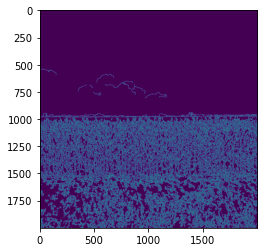

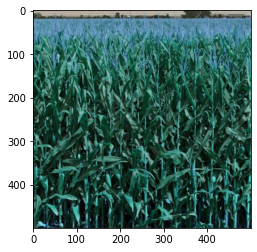

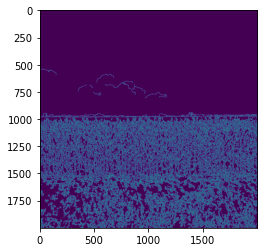

In [ ]:
file = '/content/drive/MyDrive/GSV Github/QDWxWb7c1sVcLeoquYPTHw_41.54170024691091_-88.29999867944885_2021_8_358.7471008300781.jpg'
image = cv2.imread(file)

# kernel = np.ones((5,5),np.float32)/10
# image_blur = cv2.filter2D(image,-1,kernel)
image_blur = cv2.medianBlur(image,5)

#converting to gray scale
gray=cv2.cvtColor(image_blur,cv2.COLOR_BGR2GRAY)
#applying canny edge detection
edged = cv2.Canny(image_blur, 10, 150)
plt.imshow(edged)
plt.show()

df = pd.DataFrame(edged)
count_255 = df.ne(0).sum(1)
crop_horizontal_line = 0
i = 0

while crop_horizontal_line<750:
    crop_horizontal_line = count_255[count_255>150].index[i]
    i += 1

# crop_horizontal_line = count_255[count_255>250].index[1]
crop_image = image[crop_horizontal_line:crop_horizontal_line+500,750:1250,:]
cv2.imwrite('/content/drive/MyDrive/GSV Github/QDWxWb7c1sVcLeoquYPTHw_41.54170024691091_-88.29999867944885_2021_8_358.7471008300781_clipped.jpg', crop_image)
plt.imshow(crop_image)
cv2.imwrite('/content/drive/MyDrive/GSV Github/QDWxWb7c1sVcLeoquYPTHw_41.54170024691091_-88.29999867944885_2021_8_358.7471008300781_edged.jpg', edged)
plt.show()
plt.imshow(edged)

## Relabel GSV images by visual interpretation

# GSV images classification

## Proposed deep learning model (ViTResFusionNet)

In [ ]:
!pip install split-folders
!pip install -U transformers datasets
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

cudnn.benchmark = True

In [ ]:
!pip install -U transformers datasets
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
import torch
from torch import nn
from datasets import load_dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = '/content/drive/MyDrive/Crop Classification/test_4species_split/'
dataset = load_dataset(name="avengers", path=DATASET_DIR, data_files={"train": "/content/drive/MyDrive/Crop Classification/test_4species_split/train/**" \
                                                                      , "test": "/content/drive/MyDrive/Crop Classification/test_4species_split/val/**"})
inputsize = 500
labels = dataset['train'].features['label'].names
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs
feature_extractor = ViTFeatureExtractor(size=inputsize,image_mean = [0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
prepared_ds = dataset.with_transform(transform)

In [ ]:
model_rn = models.resnet50(pretrained=True)
# append_dropout(model_ft, rate=0.2)
num_ftrs = model_rn.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_rn.fc = nn.Linear(num_ftrs, 768)

from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
import torch
from torch import nn
model_name_or_path = 'google/vit-base-patch16-224-in21k'
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor = ViTFeatureExtractor(size=500,image_mean = [0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
model_vit = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
model_vit.classifier= nn.Identity()



In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self._fc1 = nn.Linear(768 * 2, 768)
        self.classifier = nn.Linear(768, 5)
        
        
    def forward(self, x):
        x1 = self.modelA(x,interpolate_pos_encoding = True).logits
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)  
        x = self._fc1(x)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_vit, model_rn)

for param in ensemble_model.parameters():
    param.requires_grad = True

# for param in ensemble_model.classifier.parameters():
#     param.requires_grad = True    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from torch import nn
from datasets import load_dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = '/content/drive/MyDrive/Crop Classification/test_4species_split/'
dataset = load_dataset(name="avengers", path=DATASET_DIR, data_files={"train": "/content/drive/MyDrive/Crop Classification/test_4species_split/train/**" \
                                                                      , "test": "/content/drive/MyDrive/Crop Classification/test_4species_split/val/**"})

labels = dataset['train'].features['label'].names

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(500),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(500),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = DATASET_DIR
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
train_loader = dataloaders['train']
test_loader  = dataloaders['val']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes  = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## https://github.com/MicrosoftDocs/ml-basics/blob/master/05c%20-%20Transfer%20Learning%20(PyTorch).ipynb
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = ensemble_model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
# optimizer = optim.Adam(model.parameters(), lr=0.0005)


# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()


# # Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 150
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

## Benchmarks

### ResNet50

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

cudnn.benchmark = True


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
inputsize = 500
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(inputsize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(inputsize),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Crop Classification/test_4species_split/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
epoch =100
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=epoch)
model_dir = '/content/drive/MyDrive/Crop Classification/Results/ResNet+Cropped Images/'
torch.save({
              'epoch': epoch,
              'model_state_dict': model_ft.state_dict(),
              'optimizer_state_dict': optimizer_ft.state_dict(),
              'loss': criterion,
              }, os.path.join(model_dir, 'epoch-{}.pth'.format(epoch)))

### ViT

In [ ]:
!pip install split-folders
!pip install -U transformers datasets

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, BatchFeature
import requests
from io import BytesIO
from PIL import Image
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### Load trained parameters
# model_name_or_path = '/content/drive/MyDrive/Crop Classification/vit-test_4species_split-500'
## this is ViT trained using 'google/vit-base-patch16-224' and updated training dataset.
model_name_or_path = '/content/drive/MyDrive/Crop Classification/Results/ViT_Cropped_finetune_South_4species' 

# feature_extractor = ViTFeatureExtractor(size=500,image_mean = [0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(model_name_or_path).to(device)
model.config.output_attentions = True
model_ft.eval()

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
import torch
from torch import nn
from datasets import load_dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = '/content/drive/MyDrive/Crop Classification/test_4species_split/'
dataset = load_dataset(name="avengers", path=DATASET_DIR, data_files={"train": "/content/drive/MyDrive/Crop Classification/test_4species_split/train/**" \
                                                                      , "test": "/content/drive/MyDrive/Crop Classification/test_4species_split/val/**"})
inputsize = 500
labels = dataset['train'].features['label'].names
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs
feature_extractor = ViTFeatureExtractor(size=inputsize,image_mean = [0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
prepared_ds = dataset.with_transform(transform)

In [ ]:


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


model_name_or_path = 'google/vit-base-patch16-224-in21k'
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor = ViTFeatureExtractor(size=500,image_mean = [0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

model.config.attention_probs_dropout_prob =0.2
model.config.hidden_dropout_prob =0.2

training_args = TrainingArguments(
  output_dir="/content/drive/MyDrive/Crop Classification/vit-test_4species_split",
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=20,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True)

class ViTTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs,interpolate_pos_encoding = True)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss().to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1)).to(device)
        return (loss, outputs) if return_outputs else loss



trainer = ViTTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)





train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)